# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 6: Ensemble Methods, and Neural Networks


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [ ]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

Import libraries:

In [131]:
import numpy as np
from numpy import arange, sin, pi, cos
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.utils import to_categorical

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.

In [132]:
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

In [133]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


In [134]:
X_train = data_train.iloc[:, data_train.columns != 'class']
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class']
y_test = data_test['class'].values

# was told not to normalize/standardize by Patrick, so removed those lines.

X_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957


## Question 1 (12pts): A Single Model
We start by fitting a basic model we can compare the other models to. We'll pick an optimally-tuned decision tree as the base model, because we'll later include random forests and want a fair comparison.

<div class='exercise'> Question 1</div>
** 1.1**  Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

**1.3** Report the model's classification accuracy on the test set.

**Answers**:  
**1.1:** Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

In [135]:
max_depths = np.linspace(1, 20, 20)

train_scores = []
train_std = []

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(np.mean(scores))
    train_std.append(2*np.std(scores))
    print("depth {:.0f}: {:.3f} +/- {:.3f}".format(max_depth, np.mean(scores), 2*(np.std(scores))))

depth_df = pd.DataFrame({'depth': max_depths, 'score': train_scores, 'std_dev': train_std})
depth_df['+2dev'] = depth_df['score'] + depth_df['std_dev']
depth_df['-2dev'] = depth_df['score'] - depth_df['std_dev']

# resource: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

depth 1: 0.599 +/- 0.022
depth 2: 0.621 +/- 0.025
depth 3: 0.621 +/- 0.036
depth 4: 0.640 +/- 0.022
depth 5: 0.642 +/- 0.017
depth 6: 0.635 +/- 0.017
depth 7: 0.633 +/- 0.019
depth 8: 0.628 +/- 0.016
depth 9: 0.617 +/- 0.033
depth 10: 0.613 +/- 0.020
depth 11: 0.614 +/- 0.021
depth 12: 0.604 +/- 0.017
depth 13: 0.603 +/- 0.019
depth 14: 0.596 +/- 0.017
depth 15: 0.594 +/- 0.018
depth 16: 0.586 +/- 0.017
depth 17: 0.595 +/- 0.022
depth 18: 0.583 +/- 0.016
depth 19: 0.590 +/- 0.013
depth 20: 0.590 +/- 0.014


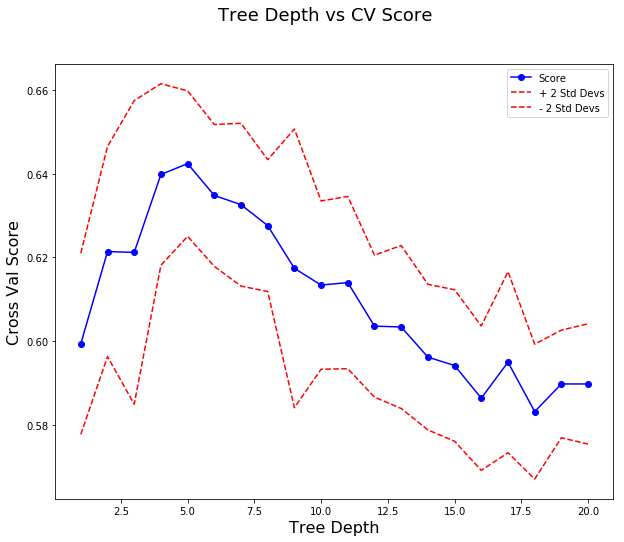

In [136]:
plt.subplots(1,1,figsize=(10,8))
plt.plot(depth_df['depth'], depth_df['score'], marker='o', label='Score', color='b')
plt.plot(depth_df['depth'], depth_df['+2dev'], 'r--', label='+ 2 Std Devs', color='r')
plt.plot(depth_df['depth'], depth_df['-2dev'], 'r--', label='- 2 Std Devs', color='r')
plt.ylabel('Cross Val Score', fontsize=16)
plt.xlabel('Tree Depth', fontsize=16)
plt.suptitle('Tree Depth vs CV Score', fontsize=18)
plt.legend();

** 1.2** Select an apropriate maximum depth-of-tree, and justify your choice.

In [137]:
depth_df[['depth', 'score']]

,depth,score
0,1.0,0.599405
1,2.0,0.621407
2,3.0,0.621213
3,4.0,0.639809
4,5.0,0.642404
5,6.0,0.634806
6,7.0,0.632606
7,8.0,0.627604
8,9.0,0.617401
9,10.0,0.613409


In [138]:
print('Max depth of 5 produces highest CV score, therefore picked 4')

print('Score on Train Set:', DecisionTreeClassifier(max_depth=4).fit(X_train, y_train).score(X_train, y_train))

Max depth of 5 produces highest CV score, therefore picked 4
Score on Train Set: 0.6614


Through 5-fold cross validation on the tree for 20 different depths, a max-depth of 5 producd the highest CV score. However, we don't neccescarily want the max cross-val score, but instead one within 1-2 standard devations of the max, so the model doesn't overfit on the training data. Therefore, I would pick a max-depth of 4 because it is within 1-2 std dev of the max CV score that max depth 5 produced.

**1.3** Report the model's classification accuracy on the test set.

In [139]:
print('Models Classification Accuracy on Test Set at Depth 4', 
      DecisionTreeClassifier(max_depth=4).fit(X_train, y_train).score(X_test, y_test))

Models Classification Accuracy on Test Set at Depth 4 0.651


## Question 2 (14 pts): Bagging
Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the combined accuracy.

<div class='exercise'> Question 2</div>
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

Store these results as `bagging_train` and `bagging_test`.

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

In [150]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss,axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

**Answers**:  
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. In particular, produce a dataset similar to 2.1, where each row is a training example, each column is a tree from the forest, but each entry is that tree's prediction of the _probability_ that training example comes from class 1.

In [164]:
baglist_train = []
baglist_train = np.zeros((5000,25))
baglist_test = []
baglist_test = np.zeros((5000,25))

for number in range(25):
    new_x, new_y = resample(X_train, y_train)
    new_xtest, new_ytest = resample(X_test, y_test)
    fitted = DecisionTreeClassifier(max_depth=5).fit(new_x, new_y)
    
    score_train = fitted.predict(new_x)    
    baglist_train[:,number] = score_train
    score_test = fitted.predict(new_xtest)
    baglist_test[:,number] = score_test
    
bagging_train = pd.DataFrame(baglist_train)
bagging_test = pd.DataFrame(baglist_test)

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

In [165]:
bagging_train['avg'] = bagging_train.mean(axis=1)
bagging_train['pred'] = bagging_train['avg'].apply(lambda x: 1 if x > 0.5 else 0)

bagging_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,avg,pred
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.60,1
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.56,1
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.64,1
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.60,1
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.56,1


In [183]:
bagging_test['avg'] = bagging_test.mean(axis=1)
bagging_test['pred'] = bagging_test['avg'].apply(lambda x: 1 if x > 0.5 else 0)

bagging_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,avg,pred
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.730370,1
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.614815,1
2,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.653333,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.614815,1
4,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.576296,1


In [184]:
score = accuracy_score(y_test, bagging_test['pred'])
print('Accuracy Score on Test Set:',score)

Accuracy Score on Test Set: 0.5116


Bagging model did not provide proper accuracy acore on test set of 67-68%. However, when I removed the bootstrapping, it did provide the correct score. There seems to be some error with the resampling.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

In [217]:
# running_predictions(bagging_test[['pred']], y_test)

bootstrap = []
score = []

bootstrap.append(bagging_test.keys())

score1 = accuracy_score(y_test, bagging_test[0])
score2 = accuracy_score(y_test, bagging_test[1])
score3 = accuracy_score(y_test, bagging_test[2])
score4 = accuracy_score(y_test, bagging_test[3])
score5 = accuracy_score(y_test, bagging_test[4])
score6 = accuracy_score(y_test, bagging_test[5])
score7 = accuracy_score(y_test, bagging_test[6])
score8 = accuracy_score(y_test, bagging_test[7])
score9 = accuracy_score(y_test, bagging_test[8])
score10 = accuracy_score(y_test, bagging_test[9])
score11 = accuracy_score(y_test, bagging_test[10])
score12 = accuracy_score(y_test, bagging_test[11])
score13 = accuracy_score(y_test, bagging_test[12])
score14 = accuracy_score(y_test, bagging_test[13])
score15 = accuracy_score(y_test, bagging_test[14])
score16 = accuracy_score(y_test, bagging_test[15])
score17 = accuracy_score(y_test, bagging_test[16])
score18 = accuracy_score(y_test, bagging_test[17])
score19 = accuracy_score(y_test, bagging_test[18])
score20 = accuracy_score(y_test, bagging_test[19])
score21 = accuracy_score(y_test, bagging_test[20])
score22 = accuracy_score(y_test, bagging_test[21])
score23 = accuracy_score(y_test, bagging_test[22])
score24 = accuracy_score(y_test, bagging_test[23])
score25 = accuracy_score(y_test, bagging_test[24])
score26 = accuracy_score(y_test, bagging_test['avg'])
score27 = accuracy_score(y_test, bagging_test['pred'])


score.append(score1), score.append(score2), score.append(score3), score.append(score4), score.append(score5) 
score.append(score6), score.append(score7), score.append(score8), score.append(score9), score.append(score10) 
score.append(score11), score.append(score12), score.append(score13), score.append(score14), score.append(score15) 
score.append(score16), score.append(score17), score.append(score18), score.append(score19), score.append(score20) 
score.append(score21), score.append(score22), score.append(score23), score.append(score24), score.append(score25) 


preds = pd.DataFrame({'bootstrap': bootstrap, 'score': score})

ValueError: Classification metrics can't handle a mix of binary and continuous targets

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

Adding more bootstrapped models to this bagging ensemble will not decrease the overall accuracy score of this ensemble. Instead, it tends to taper off to stay about the same. To be cost effective, I would not do 25 different trees. I would proabbly stick to around 10 because we notice that the ensemble model's scores don't really decrease/increase after that. 

## Question 3 (6 pts): Random Forests
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

<div class='exercise'> Question 3</div>
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the bagging model from Question 2.

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Hints**:
 - Random forests do not combine each tree's prediction via a majority vote. What do they use instead?

## **Answers**:  
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the model from Question 2.

In [220]:
# 25 trees, 5 depth

RFModel = RandomForestClassifier(n_estimators=25, max_depth=5)
print('Score from RF (via .score) on Train Set:', RFModel.fit(X_train, y_train).score(X_train, y_train))
print('Score from RF (via .score) on Test Set:', RFModel.fit(X_train, y_train).score(X_test, y_test))

Score from RF (via .score) on Train Set: 0.7228
Score from RF (via .score) on Test Set: 0.6668


Question 2 produced a score of 0.5116. 3.1's Random Forest provided a large improvement in  performance with an improve to 0.6866 on the test set, which is to be expected, according to question 2.

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

For both bagging and random forest, the first steps are the same; the ensemble is created of full trees, and then each tree is trained on a bootstrap sample of the training set. Then the predictions are averaged for bagging. This is where the difference comes in.

In random forest, instead of immediately averging the predictsions, there are two improvements. The first one is that in each tree and each split, a subset of predictors is randomly selected. Then the second difference is that a predictor is choen from this subset for splitting. Then the predictions are averaged. The reason for these improvements is the correlation of the trees in an ordinary bootstrap sample. If one (or a few features) are very strong predictors for the response variable, then these features will be selected in many of the trees, causing them to become correlated.

Basically, bagging has one parameter, whereas random forests have two parameters; the first being the same as bagging, and then the second one, where a subset of features is selected at random and then the best split feature is used from the subet to split each node in a tree. RFs reduce correlation between trees by improving the variation.

resources

https://en.wikipedia.org/wiki/Random_forest#From_bagging_to_random_forests

https://www.quora.com/What-are-the-differences-between-bagged-trees-and-random-forests

## Question 4 (12 pts): Boosting
In this question we explore a counterpart to bagging, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy over the algorithm's run.

<div class='exercise'> Question 4</div>
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.  

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

**Answers**:  
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

In [22]:
model = DecisionTreeClassifier(max_depth=3)
AdaBoost = AdaBoostClassifier(base_estimator=model, n_estimators=400, learning_rate=0.05)
boost = AdaBoost.fit(X_train, y_train)

boost_train = list(boost.staged_score(X_train, y_train))
boost_test = list(boost.staged_score(X_test, y_test))

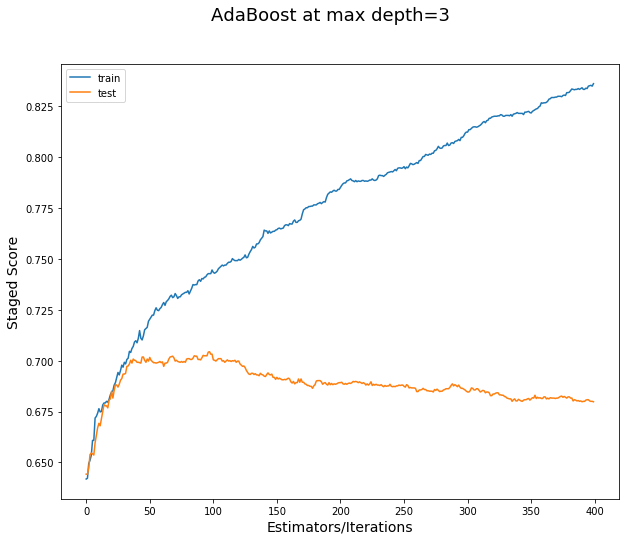

In [23]:
plt.subplots(1,1,figsize=(10,8))
x_num = np.linspace(1, 400, 400)
plt.plot(boost_train, label='train')
plt.plot(boost_test, label='test')
plt.suptitle('AdaBoost at max depth=3', fontsize=18)
plt.xlabel('Estimators/Iterations', fontsize=14);
plt.ylabel('Staged Score', fontsize=14);
plt.legend();

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

In [24]:
model1 = DecisionTreeClassifier(max_depth=1)
AdaBoost1 = AdaBoostClassifier(base_estimator=model1, n_estimators=400, learning_rate=0.05)
boost1 = AdaBoost1.fit(X_train, y_train)

boost_train1 = list(boost1.staged_score(X_train, y_train))
boost_test1 = list(boost1.staged_score(X_test, y_test))

model2 = DecisionTreeClassifier(max_depth=2)
AdaBoost2 = AdaBoostClassifier(base_estimator=model2, n_estimators=400, learning_rate=0.05)
boost2 = AdaBoost2.fit(X_train, y_train)

boost_train2 = list(boost2.staged_score(X_train, y_train))
boost_test2 = list(boost2.staged_score(X_test, y_test))

model3 = DecisionTreeClassifier(max_depth=3)
AdaBoost3 = AdaBoostClassifier(base_estimator=model3, n_estimators=400, learning_rate=0.05)
boost3 = AdaBoost3.fit(X_train, y_train)

boost_train3 = list(boost3.staged_score(X_train, y_train))
boost_test3 = list(boost3.staged_score(X_test, y_test))

model4 = DecisionTreeClassifier(max_depth=4)
AdaBoost4 = AdaBoostClassifier(base_estimator=model4, n_estimators=400, learning_rate=0.05)
boost4 = AdaBoost4.fit(X_train, y_train)

boost_train4 = list(boost4.staged_score(X_train, y_train))
boost_test4 = list(boost4.staged_score(X_test, y_test))

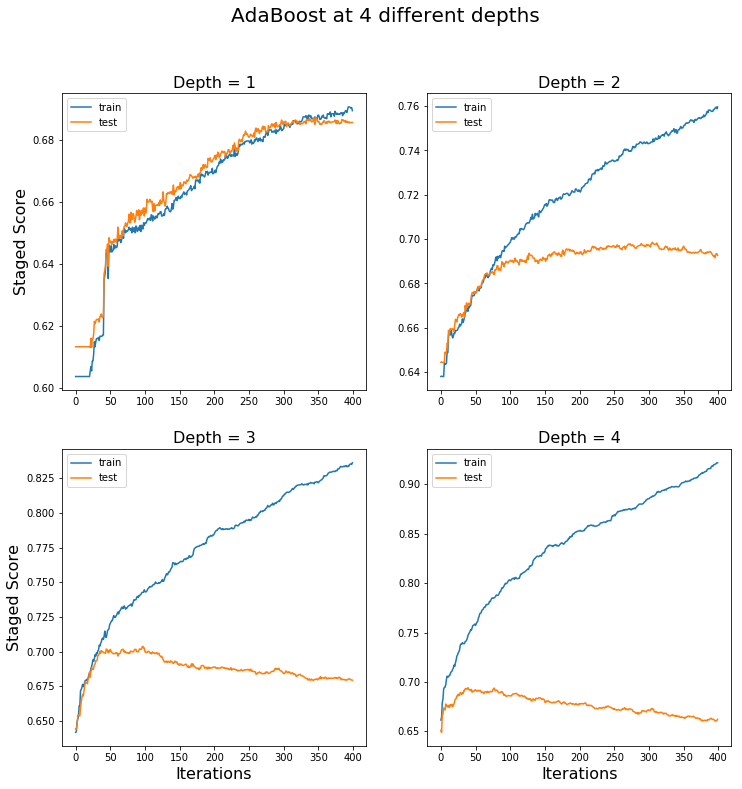

In [27]:
f, axarr = plt.subplots(2, 2, figsize=(12,12))
axarr[0, 0].plot(boost_train1, label='train')
axarr[0, 0].plot(boost_test1, label='test')
axarr[0, 0].set_title('Depth = 1', fontsize=16)
axarr[0,0].legend();
axarr[0, 1].plot(boost_train2, label='train')
axarr[0, 1].plot(boost_test2, label='test')
axarr[0, 1].set_title('Depth = 2', fontsize=16)
axarr[0,1].legend();
axarr[1, 0].plot(boost_train3, label='train')
axarr[1, 0].plot(boost_test3, label='test')
axarr[1, 0].set_title('Depth = 3', fontsize=16)
axarr[1,0].legend();
axarr[1, 1].plot(boost_train4, label='train')
axarr[1, 1].plot(boost_test4, label='test')
axarr[1, 1].set_title('Depth = 4', fontsize=16)
axarr[1,1].legend();
axarr[1,0].set_xlabel('Iterations', fontsize=16);
axarr[1,1].set_xlabel('Iterations', fontsize=16);
axarr[0,0].set_ylabel('Staged Score', fontsize=16);
axarr[1,0].set_ylabel('Staged Score', fontsize=16);
plt.suptitle('AdaBoost at 4 different depths', fontsize=20);

# resource: https://matplotlib.org/gallery/subplots_axes_and_figures/subplots_demo.html

Looking at the plot above, I noticed two distinct trends. The first trend I noticed was that for depth=1, the staged score for the test data mirrored the training data. In fact, for interations from 100 to 300, it actually overshot the scores from the training set. A second trend was evident for the other three depths. For example, the test curves reach a certain max and as we continue to do more iterations of boosting, the staged scores actually **decrease**, so our model is actually getting worse as we go more rounds of boosting.

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?


Based on the plot from 4.2, I would personally pick a max depth of the DescisionTree of 3 and make the boosting run for about 75 iterations. I picked this coombination of base learner depth and number of iterations beacuse as we can see from the graph, for more of the depths, the scores decrease as we do more iterations. Depth=3/75 iterations actually provides us with the largest staged score value of all the four different depths. If we increase/decrease depth, the scores decrease and if we increase the iterations past 75, the model is providing worsening performance with the lower scores. We want this optimal combination because too many iterations (and more depth) will overfit the model and waste computing power and take extra processing time. 

Depth 3/75 iterations provides us the best staged scores with the least amount of computing power/processing time.

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

Instead of using simple majority vote or averaging probabilities, Adaboost uses a different method to compute its data. Specifically, it assigns weighted majority votes to the classifiers and then those weights are used to favor the missclassified predictors. For example, classifiers with higher weights would be more likely to be included in the training set. After the classifier is trained, Adaboost increases the weight of the misclassified predictors so that these will make up a larger portion of the next classifiers' training set. So basically, as the next classifier is trained, the model should perform better. Basically, the algoritm sets weights on the classifiers and samples in a way that forces classifiers to concentrate on the observations that were not correctly classified.

In my opinion, I think this combination rule was chosen because we might try to minimize error via gradient descent, but in this case, error is not differentiable with respect to the predictions. Therefore the error function was replaced with a function called the exponential loss and that fxn is differentiable. This means that the gradient descent with exp loss can iteratively train the model by focuing on the points misclassified by the previous model (exactly what I said above, the misclssified predictors are assigned higher weights as we keep training the model in furthur iterations!).

resources used:

http://mccormickml.com/2013/12/13/adaboost-tutorial/

https://towardsdatascience.com/adaboost-for-dummies-breaking-down-the-math-and-its-equations-into-simple-terms-87f439757dcf

class notes

## Question 5 (18 pts): Ensembling
In this question we take the running theme of combining model to its extreme. So far, we have been combining the predictions of relatively bad models; in this section we'll combine several strong models and achieve our best accuracy yet.

We provide well-tuned models in the file `models.pkl`. The code below will read in this data for you. The model_dict object contains 5 tuned models, under the names "Ada", "KNN", "Logit", "QDA", and "RF".

**5.1**: Report each of the 5 tuned models' score on the test set, so that you can compare to these scores later.

**5.2**: Read in the fresh dataset `data/Higgs_tune.csv` Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

**5.6**: Suggest one way to improve on the model above

In [28]:
# will produce a warning under most versions of SKlearn, but it should be OK to ignore
# if you get weird errors or the models all stink, let us know

import pickle
with open("data/models.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)

In [29]:
print(model_dict)
model1 = model_dict['Ada']
model2 = model_dict['RF']
model3 = model_dict['Logit']
model4 = model_dict['QDA']
model5 = model_dict['KNN']

{'Ada': AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=50, random_state=None), 'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'Logit': Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(de

**Answers**:

**5.1**: Report each model's score on the test set, so that you can compare to these scores later.

In [30]:
print('Ada:', model1.fit(X_train, y_train).score(X_test, y_test))
print('RF:', model2.fit(X_train, y_train).score(X_test, y_test))
print('Logit:', model3.fit(X_train, y_train).score(X_test, y_test))
print('QDA:', model4.fit(X_train, y_train).score(X_test, y_test))
print('KNN:', model5.fit(X_train, y_train).score(X_test, y_test))

Ada: 0.6756
RF: 0.6746
Logit: 0.6392
QDA: 0.633
KNN: 0.5774


**5.2**: Read in the fresh dataset `data/Higgs_tune.csv`.  Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

In [33]:
data_tune = pd.read_csv('data/Higgs_tune.csv')

#normalizing data
X_train_notscaled = data_tune.iloc[:, data_tune.columns != 'class']
min_max_scaler = MinMaxScaler()
train_scaled = min_max_scaler.fit(X_train_notscaled)
X_tune = pd.DataFrame(train_scaled.transform(X_train_notscaled), columns=X_train_notscaled.columns)
y_tune = data_tune['class']

Ada = model1.fit(X_tune, y_tune).predict(X_tune)
RF = model2.fit(X_tune, y_tune).predict(X_tune)
Logit = model3.fit(X_tune, y_tune).predict(X_tune)
QDA = model4.fit(X_tune, y_tune).predict(X_tune)
KNN = model5.fit(X_tune, y_tune).predict(X_tune)

ensemble_tune = pd.DataFrame({'Ada': Ada, 'RF': RF, 'Logit': Logit, 'QDA': QDA, 'KNN': KNN})

Ada1 = model1.fit(X_tune, y_tune).predict(X_test)
RF1 = model2.fit(X_tune, y_tune).predict(X_test)
Logit1 = model3.fit(X_tune, y_tune).predict(X_test)
QDA1 = model4.fit(X_tune, y_tune).predict(X_test)
KNN1 = model5.fit(X_tune, y_tune).predict(X_test)

ensemble_test = pd.DataFrame({'Ada': Ada1, 'RF': RF1, 'Logit': Logit1, 'QDA': QDA1, 'KNN': KNN1})

In [34]:
ensemble_tune.head()

,Ada,RF,Logit,QDA,KNN
0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,0.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [35]:
ensemble_test.head()

,Ada,RF,Logit,QDA,KNN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0


**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

In [56]:
# using RandomForest

RFModel1 = RandomForestClassifier()
print('Score from RF (meta-model) on test set (via .score):', 
          RFModel1.fit(ensemble_tune, y_tune).score(ensemble_test, y_test))

Score from RF (meta-model) on test set (via .score): 0.4776


The model that I used for my meta-model is RandomForestClassifier. The meta-model does not consider one model in the data set to be more important than the others. According to the RF documentation, all classes (in this case, the five different models) are given an equal weight of one. One model is not more important than the other.

The accuracy score from the .score method provided a score of 0.4776 on the test set, which means that meta-model really did not perform very well. If we look at the individual model scores from 5.1, they are far higher (in the .57-.67 range).

sources: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

In [98]:
# combine dataframes together
augmented_tune = pd.concat([ensemble_tune, X_tune], axis=1)
augmented_test = pd.concat([ensemble_test, X_test], axis=1)

# fit DT to training
augment_model = DecisionTreeClassifier(max_depth=5)
model_fit = augment_model.fit(augmented_tune, y_tune)

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

In [99]:
new_score = model_fit.score(augmented_test, y_test)
print('Score from Meta-Tree on test set (via .score):', new_score)

Score from Meta-Tree on test set (via .score): 0.4776


Compared to 5.3, where RandomForest was used, the Desicion Tree method from 5.5 provided a slightly lower accuracy score (0.427 vs 0.4776). 

Theoretically, training a decision tree on the augmented data should perform very well because (according to the DT documention, the weighting of the different classes (columms) is not all one, like in RF. For the DTClassifier, it automatically adjusts the weights of the different classes according to: 
n_samples / (n_classes * np.bincount(y)).

One other difference between DT and RF is that a RF is a collection of DTs. A DT is built by using the whole dataset of features, but in a RF, a fraction of the number of rows is selected at random and a particular number of features are then selected randomly to train on. Then the tree is built on this subset.

Having a combination of the original data and model predictions should perform very well because it not only combines the real data, but also the predictions from the data, so, in this case, 5 different models have added their own predictions to the data set and the DT is very well fit (possibly even overfit?) to the augmented data. In this case, it might be possible that the DT is overfit because our accuracy score has actually decreased.


sources:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://www.quora.com/What-is-the-difference-between-random-forest-and-decision-trees

**5.6**: Suggest one way to improve on the model above

In [104]:
augment_model = DecisionTreeClassifier()
model_fit = augment_model.fit(augmented_tune, y_tune)
new_score = model_fit.score(augmented_test, y_test)
print('Score from Meta-Tree on test set MODIFIED:', new_score)

Score from Meta-Tree on test set MODIFIED: 0.5276


One possible way to improve the model above would be to get rid of the max_depth constraint in the DecisionTreeClassifier function. As shown above, replacing max_depth=5 to the default setting (where the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples [off the documention]), it improves the accuracy score by around 3-5%.

Another possibility could be to bootstrap (maybe 5x?) the original tuning data and add that to the augmented data sets.

source: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Question 6 (12 pts): Understanding
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

<div class='exercise'> Question 6</div>
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

**6.4** Suppose you have 10,000 training observations and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

**Answers**:  
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

The common feautre to all of them is that they are all machine learning techniques/algorithms that produce a distribution of machine learning models on subsets of the original data. From there, they all combine the distrubition into one aggregation model (seperately). 

Their unique features:

Ensembling: this is less of an algoritm and more of a technique where multiple models are applied to the original data without any special weight. We then take the meta-level and use a seperate model for the entire data together with the outputs from the multiple models to figure out which model performs well or badly.

Bagging: This technique decreases the *variance* of our predictions by generating extra data from the original dataset by using bootsrapping to produce multiple sets (randomized) of the same data. As the training set size increases, the predictions of the model don't improve. Instead, the variance is decreased; allowing the algorithm to predict what we want it to predict.

Boosting: This algorithm is unique because it uses two seperate steps. It first uses subsets of the training data to produce mulitple models. The poorly performing models are then given higher weight (more importance) in later iterations, so the overall model's performacne is "boosted". Here, the subset selection is not random and depends on the performance as I said before. Every new subset will proabbly contain points that were missclassified in previous rounds of boosting. Therefore, in this model, we are decreasing *bias*, instead of variance in bagging.

resource: https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

Bagging is better suited to parallelization because each model is built independently of each other, so mulitiple computers can be working on a problem at the same time. Boosting does not do this because it bascially tries to augment every new subset of the original data by picking out the poorly performing elements from the previous model by weighting. Therefore, bagging is probably way better suited for parallelization, whereas boosting is a sequential ensemble where multiple computers cannot work on it at the same time.

resources: 

https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning

https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

Boosting: the impact of too many iterations of boosting is that the model gets overfit and actually decrease the accuracy score (as we saw in this hw on problem 4).

Bagging: the impact of too many trees is the increased correlation between the trees, which means that we have strong predictors. At some point, the trees would up end up looking very similar beacuse it does not reduce variance if the festures are correlated. You really don't lose anything by having too many trees, but we also don't gain anything from it either.

Between the two, I would say that overfitting is worse because we are wasting resources and time waiting for the computations to occur. In fact, we will probably get worse data by overfitting.

resource: https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons

**6.4** Suppose you have 10,000 training examples and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging general) tie to overfitting versus underfitting?


For this data set and linear regression, I think that bagging would help the model more because it allows us to record the total amount that the RSS has decreased due to splits over a given predictor. A large value would mean an important predictors. Since linear regression uses RSS (residual sum of squares), I think that this would be the proper tehcnqiue to use. The bagging tree is down by splitting the samples in the leaf, such as we are maximizing the drop in RSS.

I think that the bagging has the possiblity to underfit because are we are maximizing the drop in RSS and bagging decreases the variance. As said in 6.3, boosting is prone to overfitting, whereas overfitting/having too many trees in bagging, doesn't hurt the data set. In fact, we might underfit if the model is allowed to have enough depth or have enough leaves. Since bagging decreases variance, this ties into underfitting because it means low variance and high bias, and the opposite for boosting, which decrases bias and increases variance. 

Resources:

http://people.math.umass.edu/~anna/stat697F/Chapter8_part2.pdf

https://web.stanford.edu/class/stats202/content/lec20.pdf

https://datascience.stackexchange.com/questions/28299/when-does-boosting-overfit-more-than-bagging

<hr style='height:2pt'>
## Question 7 (26 points): Neural Networks
Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> Question 7</div>
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**7.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [105]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [106]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

**Answers**:  
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

Yes, visually, we can say that X_train[0] is a sin curve


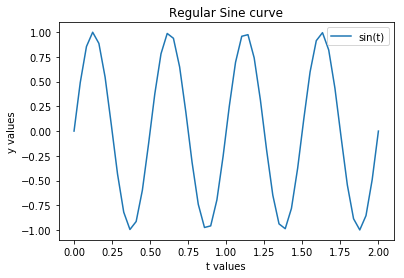

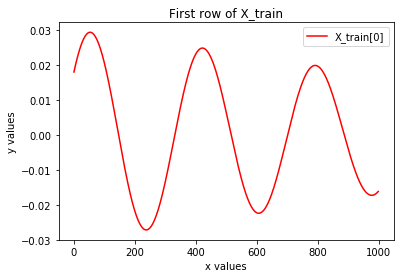

In [107]:
plt.figure(1)
t = np.linspace(0,2)
plt.plot(t, sin(2*2*pi*t), label='sin(t)')
plt.xlabel('t values')
plt.ylabel('y values')
plt.title('Regular Sine curve');
plt.legend();

plt.figure(2)
plt.plot(X_train[0], color='r', label='X_train[0]');
plt.title('First row of X_train');
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend();

print('Yes, visually, we can say that X_train[0] is a sin curve')

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

In [108]:
y_train[0]

array([0.024, 0.533, 0.018, 0.558])

YES! X_train[0] was visually verified to be the same as the given fxn!


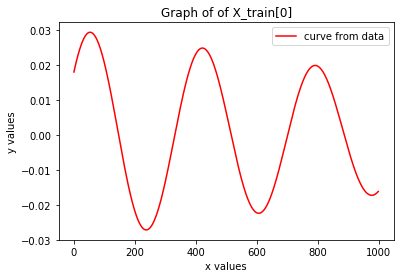

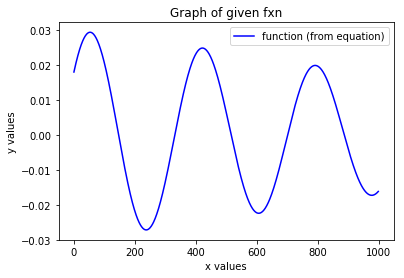

In [109]:
plt.figure(1)
x = np.linspace(0, 10*pi,1000)
plt.plot(X_train[0], color='r', label='curve from data')
plt.title('Graph of of X_train[0]');
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()

plt.figure(2)
y = (.024*sin(0.533*x)) + (0.018*cos(0.558*x))
plt.plot(y, color='b', label='function (from equation)')
plt.title('Graph of given fxn')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()

print('YES! X_train[0] was visually verified to be the same as the given fxn!')

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [110]:
# from lab 6 solutions

keras = Sequential([
    Dense(500, input_shape=(1000,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
])

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [121]:
keras.compile(loss='categorical_crossentropy', optimizer='adam')

biases = keras.layers[0].get_weights()[1]

keras.summary()

print('bias:', len(biases))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 204       
Total params: 555,854
Trainable params: 555,854
Non-trainable params: 0
_________________________________________________________________
bias: 500


According to the keras documention, in this case, the indicated # of parameters is 500500 beacuse the parameter number of calculated by the equation: [(num_features) * (num-units)] + biases, whereas bias = num_units * 1.

Therefore, it would be (1000 x 500) + 500 (bias) = 500500 (exactly the # of params given by the summary)

sources: 

https://stackoverflow.com/questions/50134334/number-of-parameters-for-keras-simplernn
https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters


**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [122]:
keras.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = .2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 172us/step - loss: 2.6102 - val_loss: 2.5598
Epoch 2/50
8000/8000 [==============================] - 1s 124us/step - loss: 2.5478 - val_loss: 2.5354
Epoch 3/50
8000/8000 [==============================] - 1s 123us/step - loss: 2.5255 - val_loss: 2.5122
Epoch 4/50
8000/8000 [==============================] - 1s 126us/step - loss: 2.5137 - val_loss: 2.5036
Epoch 5/50
8000/8000 [==============================] - 1s 126us/step - loss: 2.5092 - val_loss: 2.5127
Epoch 6/50
8000/8000 [==============================] - 1s 125us/step - loss: 2.5060 - val_loss: 2.4984
Epoch 7/50
8000/8000 [==============================] - 1s 124us/step - loss: 2.5018 - val_loss: 2.4964
Epoch 8/50
8000/8000 [==============================] - 1s 123us/step - loss: 2.4994 - val_loss: 2.4923
Epoch 9/50
8000/8000 [==============================] - 1s 125us/step - loss: 2.4984 - val_loss: 2.4886
Epoch 10/50
8000

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

In [123]:
score = keras.evaluate(X_test, y_test)

print('Keras Overall Loss (%):', score)
print('Keras Accuracy (%):', 100-score)

2000/2000 [==============================] - 0s 39us/step
Keras Overall Loss (%): 2.4990542373657227
Keras Accuracy (%): 97.50094576263427


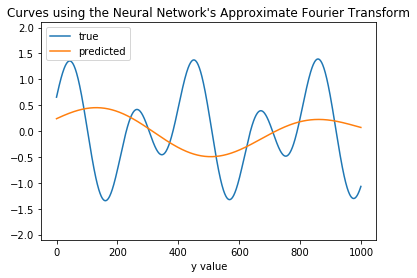

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.28227237 0.30825594 0.23913473 0.17033702]


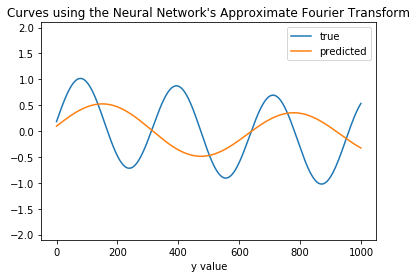

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.44887167 0.3214358  0.09559165 0.13410084]


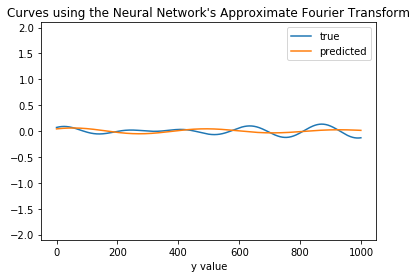

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.0444986  0.43975854 0.04245371 0.4732892 ]


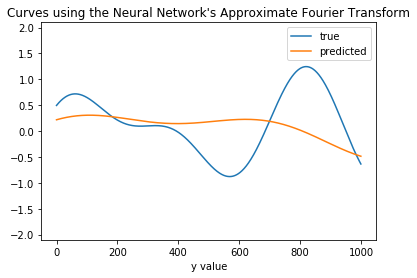

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.36784008 0.1447197  0.21839288 0.26904732]


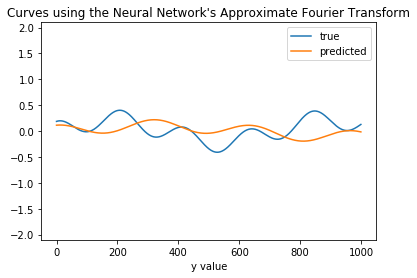

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.10566656 0.15799151 0.11384359 0.62249833]


In [124]:
plot_predictions(keras, X_test, y_test)

The model's overall loss was very low at 2.499%, which an accuracy of over 97%. With the low validation erorr of 0.02499, we can say that this model was very strong.

Looking at the plot predictions above, I would say that the model performed very well on this unseen data, especailly when we look at the different prediction lines of every graph. They tend to fit the true data very well, with good predictions (as seen by our low overall loss, and high accuracy scores).

Yes, I would say that the model has accurately learned how to map from the sample daya to the coefficients that generated the data. I am saying this due to the true vs prediction lines on the plots above. 

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

In [128]:
score = keras.evaluate(X_extended_test, y_extended_test)

print('Keras Overall Loss (%):', score)
print('Keras Accuracy (%):', 100-score)

9/9 [==============================] - 0s 177us/step
Keras Overall Loss (%): 0.7075327634811401
Keras Accuracy (%): 99.29246723651886


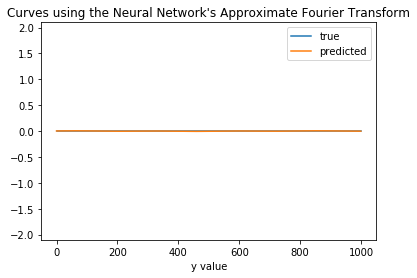

true: [0. 0. 0. 0.]
predicted: [0.00314012 0.7629783  0.00238521 0.23149638]


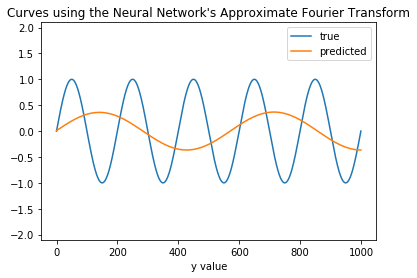

true: [1. 1. 0. 0.]
predicted: [0.35840714 0.34998104 0.00930212 0.2823097 ]


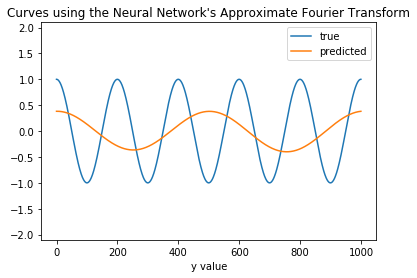

true: [0. 0. 1. 1.]
predicted: [0.01763309 0.20333165 0.38246372 0.39657155]


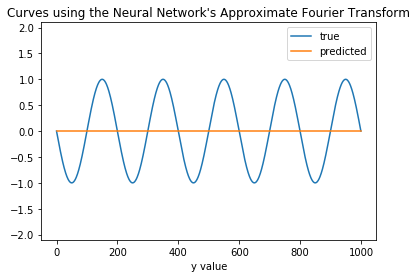

true: [-1.  1.  0.  0.]
predicted: [6.5920973e-04 5.2162562e-02 7.6402093e-21 9.4717818e-01]


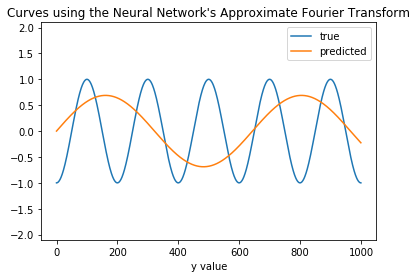

true: [ 0.  0. -1.  1.]
predicted: [6.8923557e-01 3.1063554e-01 1.5928662e-23 1.2890289e-04]


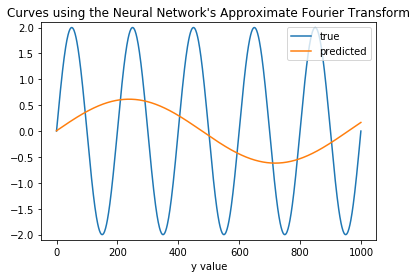

true: [2. 1. 0. 0.]
predicted: [0.6139966  0.20853366 0.00632182 0.17114787]


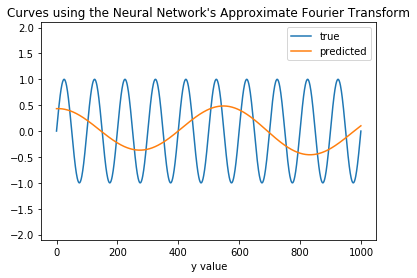

true: [1. 2. 0. 0.]
predicted: [0.07067911 0.1339394  0.433028   0.36235356]


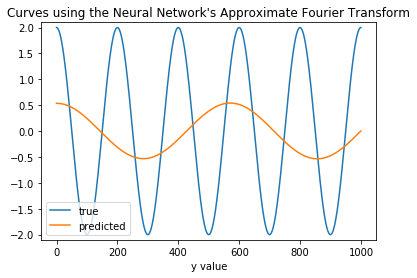

true: [0. 0. 2. 1.]
predicted: [0.00508034 0.10799234 0.536681   0.3502464 ]


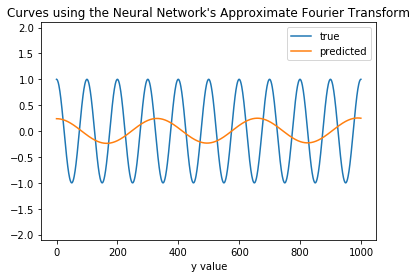

true: [0. 0. 1. 2.]
predicted: [0.15152556 0.00297471 0.2392346  0.6062652 ]


In [126]:
plot_predictions(keras, X_extended_test, y_extended_test)

Compared to 7.6, the model's validation error decreased further (down to 0.707) and improved our accuracy to 99.29%!

Looking at the prediction plots above, our model did really well on the first row [0,0,0,0] because the prediction and true values were nearly identical. Another example it did well on was the second row [1,1,0,0].

There were two examples where the model did not do very well compared to the true values. These would be the 6th row [2,1,0,0] and the last row [0,0,1,2]. The predicted curves were not as closely related to the true curve as it should have been.

**7.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

In [130]:
score = keras.evaluate(X_test, y_test)
score1 = keras.evaluate(X_train, y_train)

print('---------')
print('Training Data')
print('Keras Overall Loss (%):', score1)
print('Keras Accuracy (%):', 100-score1)
print('---------')
print('Test Data')
print('Keras Overall Loss (%):', score)
print('Keras Accuracy (%):', 100-score)

10000/10000 [==============================] - 0s 31us/step
---------
Training Data
Keras Overall Loss (%): 2.4814702713012697
Keras Accuracy (%): 97.51852972869872
---------
Test Data
Keras Overall Loss (%): 2.4990542373657227
Keras Accuracy (%): 97.50094576263427


One thing that stands out on the graphs above, especially for the difficult observations, is that the predited curve's amplitude, frequency, and wavelength's were significnatly different from the true values. This is esepcailly noticiable in the last plot of the previous problem (true=[0,0,1,2]). 

Yes, I would say that, for the most part, the model did learn the mapping that we had in mind, especially if we look at the low validation error values and accuracy scores that this implementation of a NN achieved. 

Looking at the overall loss/accuracy scores above on the training set and test set for this NN model, I would say that the model is neither overfit or underfit. It seems to be a reasonable model and does not overly fit the training data.